# Machine Learning Project

## Data cleaning and feature engineering

In [20]:
import pandas as pd
import nltk
import numpy as np
from nltk.util import ngrams
from collections import Counter
from configparser import ConfigParser
import matplotlib.pyplot as plt
from wordcloud import WordCloud
%matplotlib inline
from sklearn.feature_extraction.text import CountVectorizer
#########################################################
##                                                     ##
##              IMPORTANT                              ##
## If it's the first time you run the program, please  ##
## uncomment the following lines :                     ##
##                                                     ##
#########################################################

#nltk.dowload('punkt')
#nltk.download('stopwords')
#nltk.download('wordnet')
#nltk.download('averaged_perceptron_tagger')



In [21]:
#Load reviews and aggregate them in a str var
### Arguments : 
#   - path : The path of the file containing our data
### Output : 
#   - df : the dataframe corresponding to our data file
#   - reviews : An array containing all the reviews
def retrieveData(maindf, asint= 'B005SUHPO6'):
    df = maindf[maindf.asin == asint]
    reviews = []
    for review in df['reviewText'].items():
        reviews.append(review[1])

    return (df, reviews)

In [206]:
#Tokenize and return ('word',#apparitions) for the most common nb_token
def tokenize(reviews, nb_tokens=100):
    #We start with a string containg all the reviews
    #We retrieve all the words, then only keep alphabetic ones (no numbers)
    tokens = nltk.tokenize.word_tokenize(reviews)
    alpha_tokens = [t for t in tokens if t.isalpha()] 
    #We get rid of capital letters, in order to count word occurence properly
    lower_tokens = [t.lower() for t in alpha_tokens]
    

    #Lemmatizer
    wordnet_lemmatizer = nltk.stem.WordNetLemmatizer()
    lemmatized_tokens = [wordnet_lemmatizer.lemmatize(t) for t in lower_tokens]
    
    #Get words tag
    tagged = nltk.pos_tag(lemmatized_tokens)
    
    #We get rid of stop words 
    stop_words = nltk.corpus.stopwords.words('english')
    new_sw = ['phone','wa','work','month','year','day','iphone', 'time','ha','way','wife', 'week', 'money','doe']
    stop_words.extend(new_sw)
    no_stops_tokens = [t for t in tagged if t[0] not in(stop_words)]
    
    count = Counter(no_stops_tokens)
    return count.most_common(nb_tokens)

In [207]:
#Tag filter
def tag(tokens_tag, tag):
    return [t[0][0] for t in tokens_tag if t[0][1] == tag]

In [208]:
#Extract most relevant features from all the reviews
def extract(reviews):
    totalReviews = " "
    for review in reviews:
        totalReviews = totalReviews + review + "\n"
        
    # Retrieve the 300 most common relevant words 
    token_tag_count = tokenize(totalReviews, 500)
    tokens_tag = [[t[0],t[1]] for t in token_tag_count]
        
    # Retrieve the nouns out of the 300 most common words
    nouns = tag(tokens_tag, 'NN')
    print('nouns : ', nouns[0:30])
    #adjectives=tag(tokens,'JJ')
    #return nouns[0:30], adjectives[0:20]
    return nouns[0:30]

In [209]:
#Filtering most common words if reviews
def filter(review, features):
    tokens = [t[0][0] for t in tokenize(review)]
    filtered_tokens = [t for t in tokens if t in features]
    return filtered_tokens

In [210]:
def prepareData(df, reviews):
    # We call the extract method to retrieve the most relevant words (features)
    features = extract(reviews)  
    
    # For each review, we only keep the words that are features
    filtered_tokens = [filter(review, features) for review in reviews]
    filtered_reviews = []
    for f in filtered_tokens:
        review = ""
        for t in f:
            review = review + t + " "
        filtered_reviews.append(review)

    # We create a column for each feature
    # If that feature is mentioned in the review : the value is 1, else 0
    cv = CountVectorizer(binary=True)
    x = cv.fit_transform(filtered_reviews)
    return pd.DataFrame(x.toarray(), columns=cv.get_feature_names())

In [211]:
config = ConfigParser()
config.read('init.cfg')
path = config['RESOURCES']['path']
dataFile = config['RESOURCES']['dataFile']
# We retrieve a dataframe corresponding to our data file
# and an array containing only the reviews
maindf = pd.read_json(path + 'Cell_Phones_and_Accessories_5.json', lines = True)
df, reviews = retrieveData(maindf, 'B000S5Q9CA')

# We add to it columns. One for each feature (relevant word).
# If a review contains a feature, the corresponding column will have value 1, else 0.
df_features = prepareData(df, reviews)

nouns :  ['charger', 'car', 'motorola', 'charge', 'price', 'light', 'blue', 'product', 'cord', 'power', 'battery', 'device', 'samsung', 'quality', 'thing', 'problem', 'galaxy', 'cable', 'amazon', 'vehicle', 'droid', 'night', 'plug', 'micro', 'item', 'adapter', 'issue', 'review', 'gps', 'use']


In [212]:
df_features.head()

,adapter,amazon,battery,blue,cable,car,charge,charger,cord,device,...,power,price,problem,product,quality,review,samsung,thing,use,vehicle
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,1,1,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,0,1,1,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,1,0,0,1,0,1,0,...,0,0,0,1,0,0,0,0,0,0


In [213]:
nbrvw = maindf.groupby(['asin']).agg('count').sort_values('overall', ascending = False)

In [214]:
nbrvw.head()

,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
asin,,,,,,,,
B005SUHPO6,837,837,837,837,837,836,837,837
B0042FV2SI,694,694,694,694,694,690,694,694
B008OHNZI0,657,657,657,657,657,657,657,657
B009RXU59C,636,636,636,636,636,634,636,636
B000S5Q9CA,628,628,628,628,628,627,628,628


In [215]:
reviews

['ok , fit my iphone',
 "Got this for my Dad to replace his car charger from Wal-****.  He loves this one.  Says it's much heavier and better quality and charges faster.  I have no personal interaction with it, but he loves it.",
 'i ordered this as a back up to ensure I would be able to use in our cars when needed',
 'My old charger didn\'t do anything for my Evo 4G - after 40 minutes of driving, the battery was maybe 1-2% higher.  This new charger (rated 950mA instead of 500) actually charges the monster Evo 4G - Even using GPS w/ Google Maps navigation and talking, the battery was fully charged at the end of that same 40 minute commute.The cable is a decent length too, and pretty flexible.Had to take off 1 star because the blue motorola "M" is waaayyyy tooooo bright at night, especially when all the other lights in my vehicle are orange/amber.  Nothing that a little black duct tape couldn\'t fix though...',
 'This product is wonderful.Positives- Brand name cable- attractive (the M l

## Data Visualization

In [216]:
dfwc=df.filter(['reviewText','overall'], axis =1)
dfwc['GoodRating'] = np.where(dfwc.overall>4,1,0)
df_pos = dfwc[dfwc['GoodRating'] == 1]
df_neg = dfwc[dfwc['GoodRating']==0]

In [217]:
reviewpos = []
for review in df_pos['reviewText'].items():
    reviewpos.append(review[1])
strpos=''.join(reviewpos)

In [218]:
reviewneg = []
for review in df_neg['reviewText'].items():
    reviewneg.append(review[1])
strneg = ''.join(reviewneg)

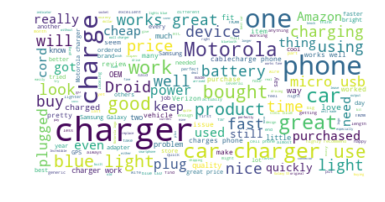

In [219]:
# Generate a word cloud image
wordcloud = WordCloud(max_font_size=40, background_color = 'white').generate(strpos)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

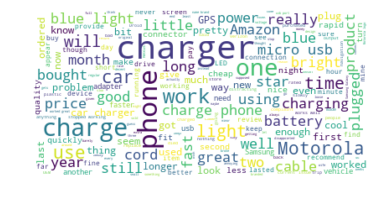

In [220]:
# Generate a word cloud image
wordcloud = WordCloud(max_font_size=40, background_color = 'white').generate(strneg)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## Model Tuning

In [221]:
dataset = df_features
dataset['GoodRating'] = np.where(df.overall>2.5,1,0)

In [222]:
X = dataset.drop(['GoodRating'], axis = 1)
y = dataset['GoodRating']

## Logistic Regression

In [223]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn import model_selection
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from treeinterpreter import treeinterpreter as ti
import json
from sklearn.preprocessing import scale
import warnings
warnings.filterwarnings("ignore")

In [224]:
#evaluate performances
from sklearn.metrics import make_scorer, accuracy_score 
from sklearn.model_selection import GridSearchCV

In [225]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                            test_size=0.20, random_state=0, stratify = y)

In [226]:
np.shape(X_train)

(502, 30)

In [227]:
cv_sets = model_selection.StratifiedShuffleSplit(n_splits = 2, test_size = 0.20, random_state = 5)
cv_sets.get_n_splits(X_train, y_train)

2

In [228]:
#Logistic Regression 
logreg_clf = LogisticRegression()

parameters_logreg = { "fit_intercept": [True, False], "solver": ["newton-cg", "lbfgs", "liblinear", "sag", "saga"],
                     "max_iter": [50, 100, 200]}

grid_logreg = GridSearchCV(logreg_clf, parameters_logreg, scoring=make_scorer(accuracy_score), cv = cv_sets)
grid_logreg.fit(X_train, y_train)

logreg_clf = grid_logreg.best_estimator_

logreg_clf.fit(X_train, y_train)
pred_logreg = logreg_clf.predict(X_test)
acc_logreg = accuracy_score(y_test, pred_logreg)

print("The Score for Logistic Regression is: " + str(acc_logreg))
grid_logreg.best_params_

The Score for Logistic Regression is: 0.9285714285714286


{'fit_intercept': True, 'max_iter': 50, 'solver': 'newton-cg'}

In [229]:
feature_to_coef = {
    word: coef for word, coef in zip(
        df_features.columns, logreg_clf.coef_[0]
    )
}

print('The most liked features are :')
for best_positive in sorted(
    feature_to_coef.items(), 
    key=lambda x: x[1], 
    reverse=True)[:5]:
    print (best_positive)
    
print('\n'+'The most disliked features are : ')    
for best_negative in sorted(
    feature_to_coef.items(), 
    key=lambda x: x[1])[:5]:
    print (best_negative)

The most liked features are :
('cord', 1.0751119087309553)
('quality', 1.0358132242363003)
('device', 1.0261099430147367)
('price', 0.8696474657343171)
('car', 0.8429379428055307)

The most disliked features are : 
('micro', -0.7374210110330561)
('night', -0.6782543735909071)
('plug', -0.582720317620821)
('review', -0.5728745072491633)
('adapter', -0.34256050344602446)


## SVM

In [230]:
svc_clf = SVC() 

parameters_svc = {"kernel": ["linear"], "probability": [True, False]}

grid_svc = GridSearchCV(svc_clf, parameters_svc, scoring=make_scorer(accuracy_score), cv = cv_sets)
grid_svc.fit(X_train, y_train)

svc_clf = grid_svc.best_estimator_

svc_clf.fit(X_train, y_train)
pred_svc = svc_clf.predict(X_test)
acc_svc = accuracy_score(y_test, pred_svc)
print("The Score for SVC is: " + str(acc_svc))
grid_svc.best_params_

The Score for SVC is: 0.9285714285714286


{'kernel': 'linear', 'probability': True}

In [231]:
np.shape(svc_clf.support_)

(125,)

In [232]:
np.shape(svc_clf.support_vectors_)

(125, 30)

In [233]:
svc_clf.support_

array([ 31,  34,  46,  52,  76,  79,  90, 118, 119, 147, 164, 177, 189,
       208, 210, 211, 220, 227, 250, 255, 261, 276, 278, 298, 306, 359,
       375, 388, 394, 416, 448, 449, 468, 471, 476,   3,   5,   7,  11,
        12,  19,  22,  25,  48,  59,  74,  75,  80,  82,  87,  96, 108,
       109, 110, 115, 121, 134, 149, 150, 152, 166, 167, 170, 184, 193,
       199, 200, 201, 203, 215, 217, 225, 226, 235, 236, 247, 268, 269,
       270, 273, 274, 285, 286, 287, 289, 290, 294, 295, 303, 304, 315,
       322, 324, 325, 333, 334, 339, 345, 362, 364, 368, 373, 376, 380,
       386, 412, 413, 418, 420, 430, 440, 443, 452, 456, 463, 465, 467,
       472, 473, 480, 481, 487, 488, 497, 501])

In [234]:
np.shape(svc_clf.coef_)

(1, 30)

In [235]:
feature_to_coef = {
    word: coef for word, coef in zip(
        df_features.columns, svc_clf.coef_[0]
    )
}
for best_positive in sorted(
    feature_to_coef.items(), 
    key=lambda x: x[1], 
    reverse=True)[:5]:
    print (best_positive)
    
    
for best_negative in sorted(
    feature_to_coef.items(), 
    key=lambda x: x[1])[:5]:
    print (best_negative)

('device', 0.0013038097468714672)
('vehicle', 0.0008730883291263748)
('quality', 0.0008553406812210996)
('cord', 0.0007536953231934104)
('charge', 0.0003271714231488673)
('samsung', -0.00040890580908667894)
('review', -0.0003996999302077508)
('adapter', -0.00037164657098121)
('plug', -0.0003378857217049558)
('micro', -0.00023803346303626289)


## Naive Bayes

In [236]:
#GaussianNB
GNB_clf = GaussianNB()
GNB_clf.fit(X_train,y_train)

pred_gnb = GNB_clf.predict(X_test)
acc_gnb = accuracy_score(y_test, pred_gnb)


print("The Score for GaussianNB is: " + str(acc_gnb))

The Score for GaussianNB is: 0.30158730158730157


In [237]:
np.shape(GNB_clf.theta_)

(2, 30)

In [238]:
GNB_clf.theta_

array([[0.08571429, 0.05714286, 0.08571429, 0.14285714, 0.05714286,
        0.14285714, 0.28571429, 0.45714286, 0.        , 0.        ,
        0.05714286, 0.02857143, 0.02857143, 0.05714286, 0.08571429,
        0.2       , 0.11428571, 0.22857143, 0.08571429, 0.08571429,
        0.08571429, 0.05714286, 0.05714286, 0.11428571, 0.        ,
        0.08571429, 0.08571429, 0.05714286, 0.2       , 0.        ],
       [0.04925054, 0.07494647, 0.08137045, 0.29978587, 0.04710921,
        0.36616702, 0.41541756, 0.5738758 , 0.11134904, 0.08779443,
        0.07708779, 0.09207709, 0.06423983, 0.04925054, 0.04282655,
        0.28907923, 0.04925054, 0.24197002, 0.06423983, 0.06852248,
        0.09421842, 0.17987152, 0.06852248, 0.12633833, 0.08993576,
        0.05567452, 0.08993576, 0.08779443, 0.14346895, 0.06423983]])

In [239]:
accuracy_score(y_train,GNB_clf.predict(X_train))

0.3386454183266932

## Decision Tree

In [240]:
#DecisionTreeClassifier 
DT_clf = DecisionTreeClassifier()

parameters_dt = {"max_depth": [5,6,7,10],"min_samples_split": [2, 3, 5, 10], "max_features": ["auto", "sqrt", "log2"],
                 "criterion": ["gini"] }

grid_dt = GridSearchCV(DT_clf, parameters_dt, scoring=make_scorer(accuracy_score), cv = cv_sets)
grid_dt.fit(X_train, y_train)

DT_clf = grid_dt.best_estimator_

DT_clf.fit(X_train, y_train)
pred_dt = DT_clf.predict(X_test)
acc_dt = accuracy_score(y_test, pred_dt)

print("The Score for DecisionTree is: " + str(acc_dt))
grid_dt.best_params_

The Score for DecisionTree is: 0.9206349206349206


{'criterion': 'gini',
 'max_depth': 10,
 'max_features': 'auto',
 'min_samples_split': 5}

In [194]:
feature_importances = DT_clf.feature_importances_

##### Interpreting contribution of each feature for a given class

In [195]:
prediction, bias, contributions = ti.predict(DT_clf, X)

In [196]:
np.shape(contributions)

(628, 30, 2)

In [197]:
totalc = np.mean(contributions, axis=0)
totalc0 = totalc[:,0]
totalc1 = totalc[:,1]

In [241]:
feature_to_coef3 = {
    word: coef for word, coef in zip(
        df_features.columns, totalc0
    )
}
for best_positive in sorted(
    feature_to_coef3.items(), 
    key=lambda x: x[1], 
    reverse=True)[:5]:
    print (best_positive)
feature_to_coef4 = {
    word: coef for word, coef in zip(
        df_features.columns, totalc1
    )
}
for best_negative in sorted(
    feature_to_coef4.items(), 
    key=lambda x: x[1], reverse = True)[:5]:
    print (best_negative)
    

('adapter', 8.077814326711993e-05)
('use', 6.256685446490309e-05)
('cord', 5.706093394484022e-05)
('droid', 3.317409766454341e-05)
('charge', 1.4163953174782582e-05)
('night', 0.0007004032792334999)
('review', 0.0004876458289836073)
('cable', 0.00040946314831665447)
('light', 6.901145724112777e-05)
('plug', 3.476653289425432e-05)
